In [2]:
from random import random
import pandas
from sklearn.model_selection import train_test_split
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import pandas as pd
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report


from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

2023-07-25 11:28:38.255640: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-25 11:28:39.233439: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-07-25 11:28:39.233567: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-07-25 11:28:39.233575: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

# IMPORT DATASET

In [3]:
chiavi=["age","sex","cp","trestbps","chol","fbs","restecg","thalach","exang","oldpeak","slope","ca","thal"]

#carico file per il dataset
heart=pandas.read_csv(r"/home/matteo/heart.csv")

#inizializzazione x
x=heart.drop("target",axis=1)

#inizializzazione y con valore target
y=heart[:]["target"].values

#split in train e test di x e y in 80/20
#0.20 43
""" random_state=43 """
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.20,random_state=43)
print("x_train: ",x_train.shape)
print("y_train: ",y_train.shape)
print("x_test: ",x_test.shape)
print("y_test: ",y_test.shape)

x_train:  (242, 13)
y_train:  (242,)
x_test:  (61, 13)
y_test:  (61,)


# HEATMAP su tutte le features

Heatmap, mi mostra la correlazione tra le features, con delle tecniche statistiche e un mapping su una scala di colori:

<AxesSubplot:>

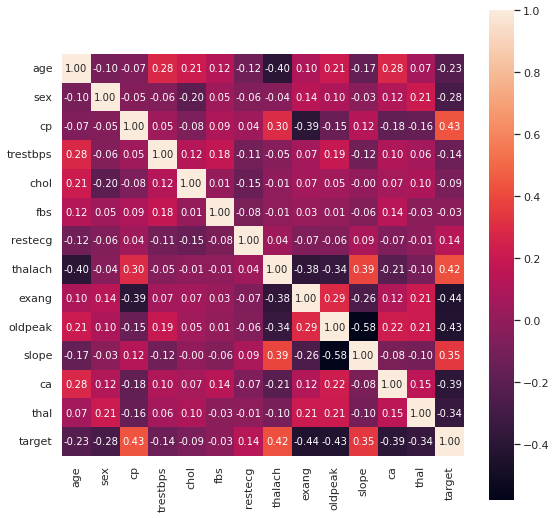

In [3]:
sns.set (rc = {'figure.figsize':(9, 9)})
sns.heatmap(heart.corr(), 
                 cbar=True, 
                 annot=True, 
                 square=True, 
                 fmt='.2f', 
                 annot_kws={'size': 10}, 
                 yticklabels=heart.columns, 
                 xticklabels=heart.columns, )

# MODELLO principale

!! Non riesco a far diminuire la loss function anche se lievemente migliora l'accuracy
prima sempre accuracy sotto il 50% con altro loss function
sparse_categorical_crossentropy sembra la più promettente
per il momento dropout non sta aiutando, e non ha aiutato neanche complicare l'architettura
so passato da un test set del 20% al 25% ed ho ottenuto miglioramenti
peggioramenti per quanto riguarda il 30% di test set
per ilmomento nessun miglioramento anchealterando numero di epoche (da 1 a 1000) e batchsize (mosso da 1 a 300)

CONFIGURAZIONE MIGLIORE ATTUALMENTE:
model.compile(optimizer="adam",loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])
model.fit(x_train,y_train,batch_size=10,epochs=100)
3/3 [==============================] - 0s 2ms/step - loss: 0.6859 - accuracy: 0.5658

rimossi tutti i drop outp (0.7), rimossi 2 layer uno da 512 e uno da 256
BEAST:
model.compile(optimizer="adam",loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])
model.fit(x_train,y_train,batch_size=10,epochs=100)
3/3 [==============================] - 0s 2ms/step - loss: 0.4288 - accuracy: 0.8289

provato ulteriormente a semplificare ma solo peggioramenti
lo stesso vale per i dropout a 0.7
provato da relu a gelu dai layer piu esterni a più interni ma senza benefit 
anzi un live benefit con tute gelu dello 0.02
stessa pratica con tanh ma lieve peggioramento
Nel caso precedente il mio input layer era di 128, più volte prendeva in inuput una riga(?)
ora con un input layer da 13 accuracy diminuita
ho recuperando impostando sull'input layer la relu e passando dai 128 ai 96 nodi del 1 layer

BEST:
23/23 [==============================] - 0s 3ms/step - loss: 0.4474 - accuracy: 0.8018
3/3 [==============================] - 0s 3ms/step - loss: 0.4269 - accuracy: 0.8421
rimossa relu su input layer, tutte gelu.

BEST:
3/3 [==============================] - 0s 6ms/step - loss: 0.3963 - accuracy: 0.8816
[0.39634600281715393, 0.8815789222717285]
aumentando le epoche a 150 e facendo vari run 

anche l'ultima funzione di attivazione nell'input layer è gelu, non da score migliori dell'88% però è molto stabile durante i vari training sull'86/87%, rispetto l'altra che ho trovato una configurazione buona tra molti run.

Epoch 1/400


2023-07-25 11:29:19.876897: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-07-25 11:29:19.876941: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Matteo-Aspire): /proc/driver/nvidia/version does not exist
2023-07-25 11:29:19.877328: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


1/1 [==============================] - 1s 817ms/step - loss: 0.6697 - accuracy: 0.6777
Epoch 2/400
1/1 [==============================] - 0s 4ms/step - loss: 0.6643 - accuracy: 0.6777
Epoch 3/400
1/1 [==============================] - 0s 5ms/step - loss: 0.6590 - accuracy: 0.6818
Epoch 4/400
1/1 [==============================] - 0s 6ms/step - loss: 0.6537 - accuracy: 0.6860
Epoch 5/400
1/1 [==============================] - 0s 6ms/step - loss: 0.6486 - accuracy: 0.6860
Epoch 6/400
1/1 [==============================] - 0s 5ms/step - loss: 0.6435 - accuracy: 0.6860
Epoch 7/400
1/1 [==============================] - 0s 6ms/step - loss: 0.6385 - accuracy: 0.6860
Epoch 8/400
1/1 [==============================] - 0s 5ms/step - loss: 0.6336 - accuracy: 0.6860
Epoch 9/400
1/1 [==============================] - 0s 5ms/step - loss: 0.6288 - accuracy: 0.6942
Epoch 10/400
1/1 [==============================] - 0s 5ms/step - loss: 0.6240 - accuracy: 0.6983
Epoch 11/400
1/1 [=====================

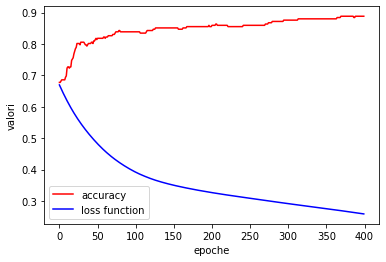

<bound method Model.summary of <keras.engine.sequential.Sequential object at 0x7f0376f48790>>

In [6]:
model = tf.keras.Sequential([
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(13,tf.keras.activations.relu,input_shape=(13,)),
    tf.keras.layers.Dense(2,tf.keras.activations.softmax)
])

""" 
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(13,tf.keras.activations.relu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.8),
    tf.keras.layers.Dense(96,tf.keras.activations.gelu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(64,tf.keras.activations.gelu),
    tf.keras.layers.Dense(32,tf.keras.activations.gelu),
    tf.keras.layers.Dense(16,tf.keras.activations.gelu),
    tf.keras.layers.Dense(8,tf.keras.activations.gelu),
    tf.keras.layers.Dense(4,tf.keras.activations.gelu),
    tf.keras.layers.Dense(2,tf.keras.activations.softmax) """

model.compile(optimizer=tf.keras.optimizers.Adam(),loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])
storia = model.fit(x_train,y_train,batch_size=300,epochs=400)
_,accuracyModel = model.evaluate(x_test,y_test)
print(accuracyModel)

plt.plot(storia.history['accuracy'], color = 'red')
plt.plot(storia.history['loss'], color = 'blue')
plt.xlabel('epoche')
plt.ylabel('valori')
plt.legend(['accuracy','loss function'])
plt.show()
model.summary

## visualizzazione modello principale

2/2 [==============================] - 0s 2ms/step


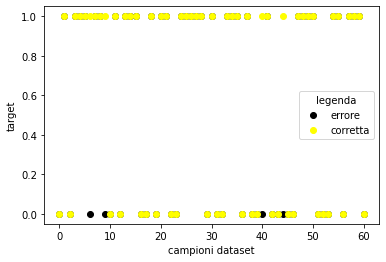

In [7]:
y_predette = model.predict(x_test)
array = []
y_pred_custom = []
j=0

for i in y_predette:
    # se [1,2] se 1 è vicino allo 0 vuol dire che devo prendere il valore 2, quanto è vicino all'_1
    # se 1 è vicino all'uno vuol dire che mi servirà 1-quel valore ovvero il valore 2
    y_pred_custom.append(i[1])
    array.append(j)
    j+=1

y_pred_arrotondate = []
for i in y_pred_custom:
    if i < 0.5:
        y_pred_arrotondate.append(0)
    else:
        y_pred_arrotondate.append(1)

# Crea il grafico con l'array di valori
plt.scatter(array,y_test,c='black')
plt.scatter(array,y_pred_arrotondate,c='yellow')
#plt.axhline(y=0.5,c='black')
plt.xlabel('campioni dataset')
plt.ylabel('target')
plt.legend(['errore','corretta'],title='legenda')
plt.show()

# FEATURES SELECTION
## Heatmap rimuovendo 1 features a giro

Heatmap segna una features, per ogni features, l'idea era di fare un po di features selection, ma ad occhio non rendono molta differenza, non ho trovato nulla per fare una differenza tra le heatmap (la cosa più veloce sta sotto):
Rimuovendo  una features ogni volta

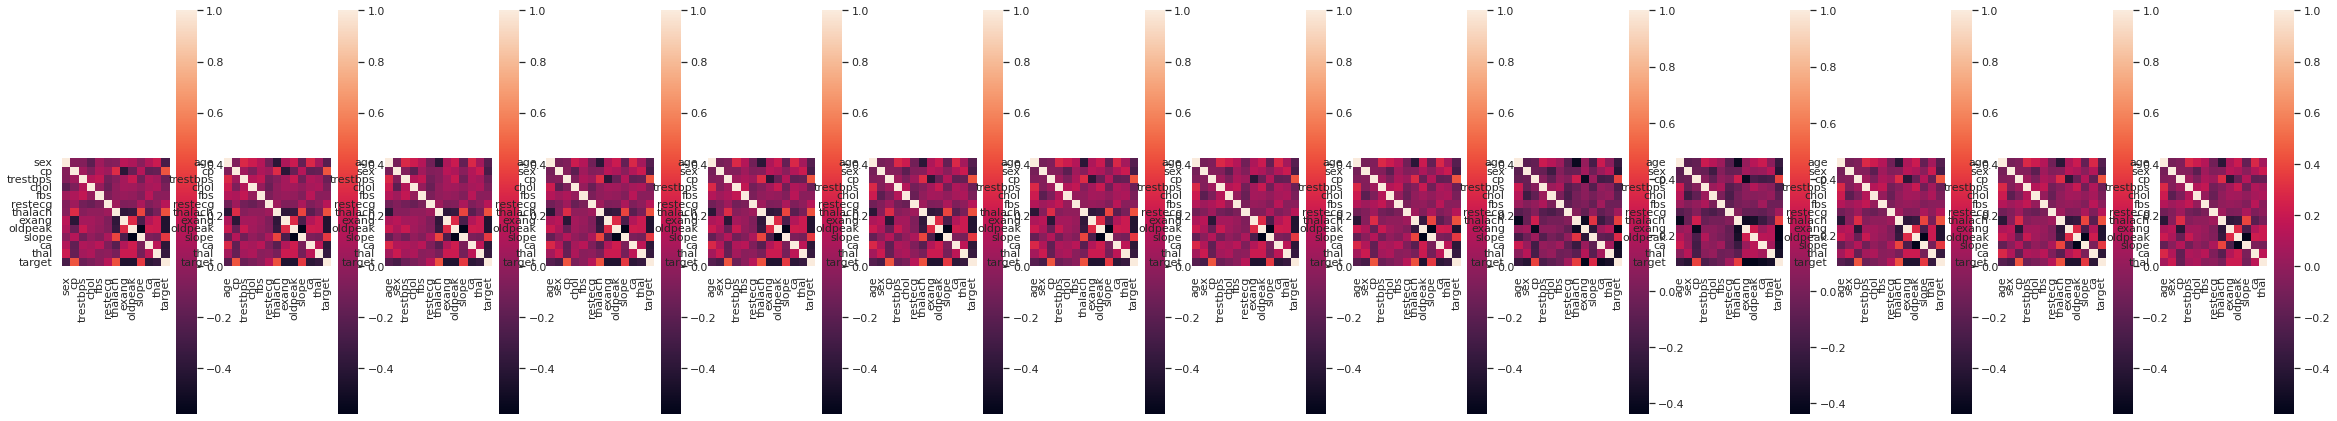

In [6]:
fig = plt.figure(figsize = (40,40)) # width x height
index=1
for i in heart:
    ax1 = fig.add_subplot(1, 14, index) # row, column, position
    h = heart.drop(columns=[i])
    sns.set (rc = {'figure.figsize':(6, 6)})
    hm = sns.heatmap(h.corr(), 
                    cbar=True, 
                    #annot=True, 
                    square=True, 
                    fmt='.2f', 
                    annot_kws={'size': 10}, 
                    yticklabels=h.columns, 
                    xticklabels=h.columns, ax = ax1)

    index+=1
plt.show()

## FEATURES SELECTION rimuovendo a mano la features 1 a giro

Features selection a mano, l'unica pecca è lo split sarebbe ottimo farlo una volta soltanto e non rifarlo ogni volta
ora ho impostato il seed ed in teoria dovrebbe farmi sempre lo stesso split (il problema che scambio delle colonne quindi non ne sono particolarmente sicuro che sia sempre lo stesso):

--------------------------------------- FEATURES USATE -------------------------------------------
[] ['sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']
--------------------------------------------------------------------------------------------------
Epoch 1/400
1/1 [==============================] - 3s 3s/step - loss: 0.5849 - accuracy: 0.7137
Epoch 2/400
1/1 [==============================] - 0s 20ms/step - loss: 0.5792 - accuracy: 0.7225
Epoch 3/400
1/1 [==============================] - 0s 22ms/step - loss: 0.5735 - accuracy: 0.7225
Epoch 4/400
1/1 [==============================] - 0s 18ms/step - loss: 0.5680 - accuracy: 0.7225
Epoch 5/400
1/1 [==============================] - 0s 23ms/step - loss: 0.5626 - accuracy: 0.7269
Epoch 6/400
1/1 [==============================] - 0s 19ms/step - loss: 0.5574 - accuracy: 0.7269
Epoch 7/400
1/1 [==============================] - 0s 22ms/step - loss: 0.5522 - accuracy: 0.7313
Epoch 8/4

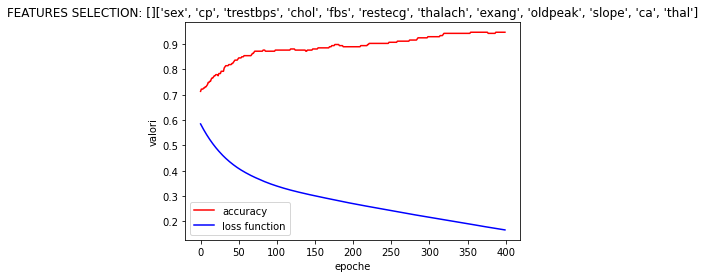

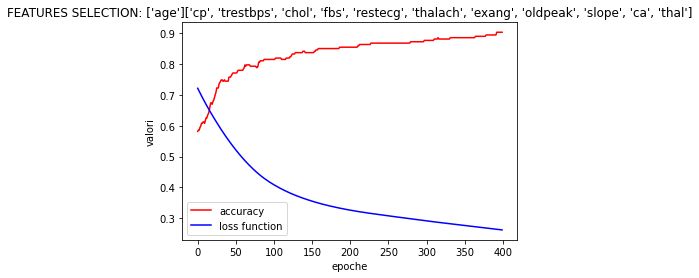

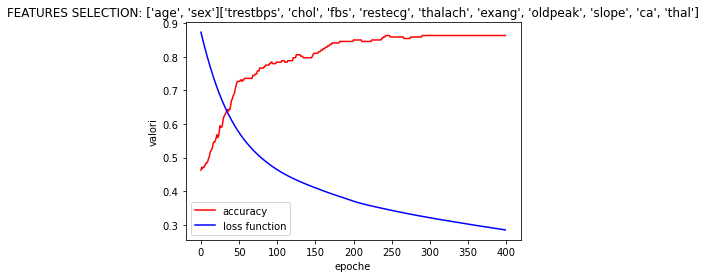

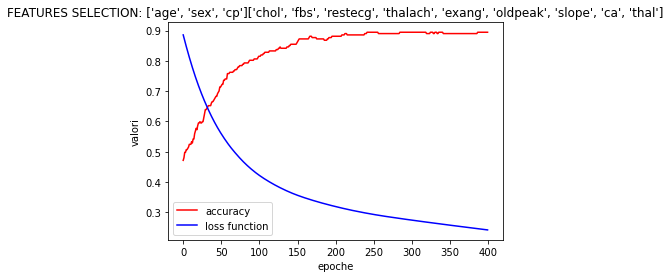

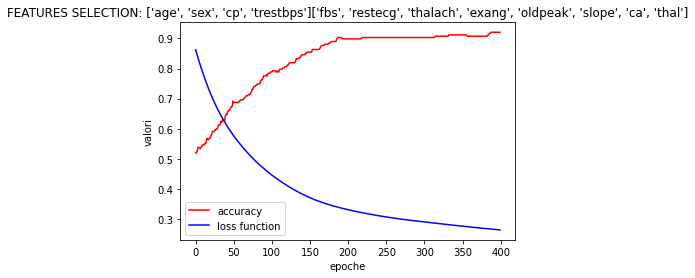

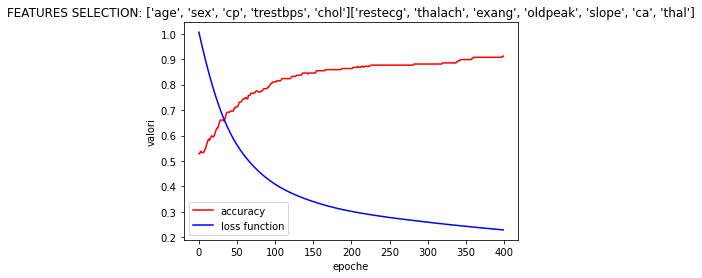

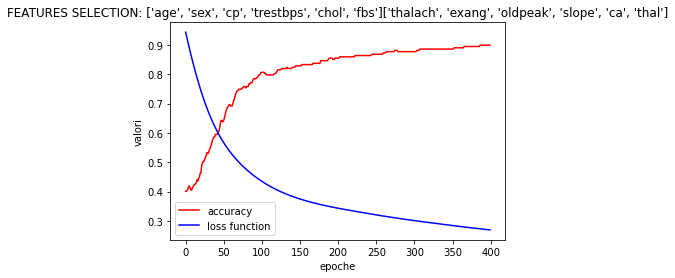

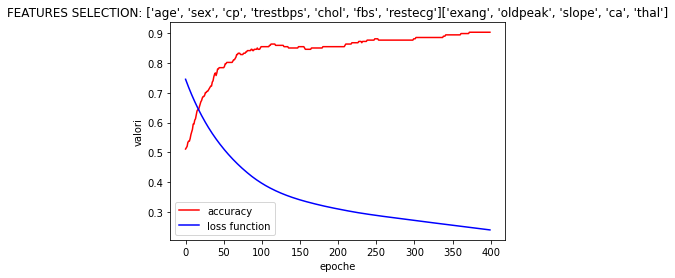

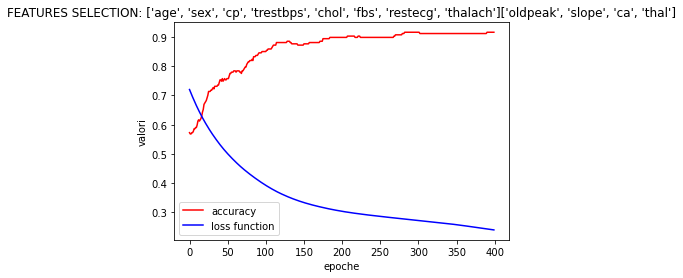

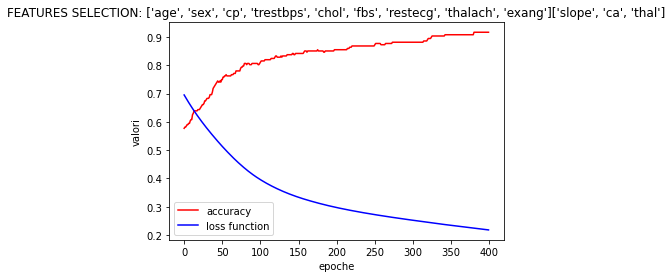

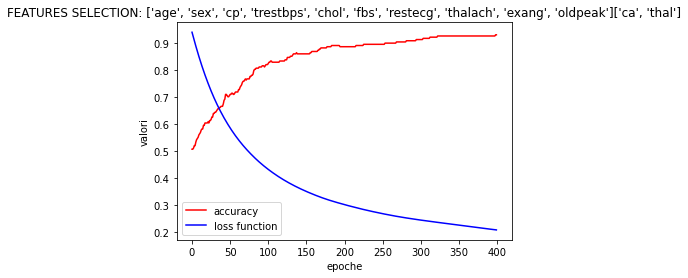

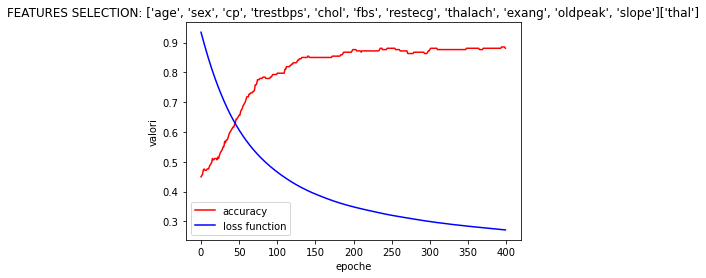

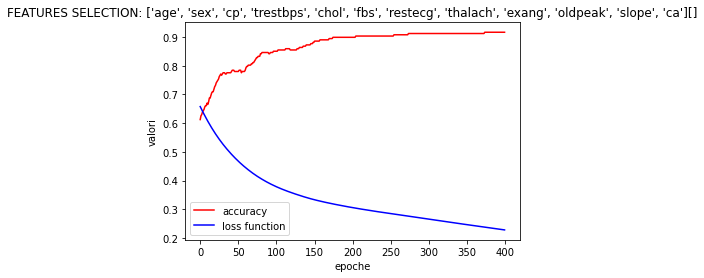

In [17]:
best_score = ['',0]
all_score = {}

for i in chiavi:
    model_1 = tf.keras.Sequential([
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(13,tf.keras.activations.relu),
        tf.keras.layers.Dense(2,tf.keras.activations.softmax)
    ])

    """ tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(12,tf.keras.activations.relu),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.4),
        #tf.keras.layers.Dense(100,tf.keras.activations.gelu),
        tf.keras.layers.Dense(96,tf.keras.activations.gelu),
        #tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(64,tf.keras.activations.gelu),
        
        #tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(32,tf.keras.activations.gelu),
        #tf.keras.layers.Dropout(0.7),
        tf.keras.layers.Dense(16,tf.keras.activations.gelu),
        #tf.keras.layers.Dropout(0.7),
        tf.keras.layers.Dense(8,tf.keras.activations.gelu),
        #tf.keras.layers.Dropout(0.7),
        tf.keras.layers.Dense(4,tf.keras.activations.gelu),
        #tf.keras.layers.Dropout(0.7),
        tf.keras.layers.Dense(2,tf.keras.activations.softmax) """

    model_1.compile(optimizer="adam",loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])

    print('--------------------------------------- FEATURES USATE -------------------------------------------')
    position = chiavi.index(i)
    print(chiavi[:position],chiavi[position+1:])
    print('--------------------------------------------------------------------------------------------------')
    
    # rimuovo features di prova
    h = heart.drop(columns=[i])
    # rimuovo target
    x_mod=h.drop("target",axis=1)
    # tengo il target
    y_mod=h[:]["target"].values
    # splitto con seed fissato ottengo sempre lo stesso splitt (in teoria)
    x_train_mod,x_test_mod,y_train_mod,y_test_mod=train_test_split(x_mod,y_mod,test_size=0.25,random_state=1)

    storia = model_1.fit(x_train_mod,y_train_mod,batch_size=300,epochs=400)
    obj = model_1.evaluate(x_test_mod,y_test_mod)

    plt.figure(i)
    plt.title('FEATURES SELECTION: '+str(chiavi[:position])+str(chiavi[position+1:]))
    plt.plot(storia.history['accuracy'], color = 'red')
    plt.plot(storia.history['loss'], color = 'blue')
    plt.xlabel('epoche')
    plt.ylabel('valori')
    plt.legend(['accuracy','loss function'])

    # salvo la migliore combo di features
    if obj[1]>best_score[1]:
        best_score = [(chiavi[:position],chiavi[position+1:]) , obj[1]]
        # carico i miglio pesi mai ottenuti li valido sullo stesso split ma con anche l'altra features
        """ model_best = tf.keras.models.load_model('/home/matteo/python/best.h5')
        obj_best = model_best.evaluate(x_test_mod,y_test_mod)
        if obj[1]>obj_best[1]: """
        #model.save('/home/matteo/python/featureSelection/bestFS.h5')
        
    # salvo risultati dei vari dataset facendo features selection
    all_score[str(chiavi[:position]+chiavi[position+1:])]= obj[1]
print(best_score)
plt.show()


# Salvare modello in caso di configurazione dei pesi ottima

In [161]:
#model.save('home/matteo/Documenti/GitHub/FromEngToArt/best3.h5')

# Modello migliore con una strutture piu complessa

Best model ever con configurazione ottima lo testo e confronto:
2/2 [==============================] - 0s 3ms/step - loss: 0.2477 - accuracy: 0.9180
[0.24771535396575928, 0.9180327653884888]

In [108]:
model_best = tf.keras.models.load_model('/home/matteo/python/best.h5')
model_best.summary()
model_best.evaluate(x_test,y_test)

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_19 (Bat  (None, 13)               52        
 chNormalization)                                                
                                                                 
 dense_96 (Dense)            (None, 4)                 56        
                                                                 
 batch_normalization_20 (Bat  (None, 4)                16        
 chNormalization)                                                
                                                                 
 dropout_9 (Dropout)         (None, 4)                 0         
                                                                 
 dense_97 (Dense)            (None, 96)                480       
                                                                 
 dense_98 (Dense)            (None, 64)              

[0.24771535396575928, 0.9180327653884888]

# Modello migliore con una struttura più snella

In [77]:
model_best = tf.keras.models.load_model('home/matteo/Documenti/GitHub/FromEngToArt/best2.h5')
model_best.summary()
model_best.evaluate(x_test,y_test)

Model: "sequential_258"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_436 (Ba  (None, 13)               52        
 tchNormalization)                                               
                                                                 
 dense_1509 (Dense)          (None, 13)                182       
                                                                 
 dense_1510 (Dense)          (None, 2)                 28        
                                                                 
Total params: 262
Trainable params: 236
Non-trainable params: 26
_________________________________________________________________
2/2 [==============================] - 0s 3ms/step - loss: 0.2546 - accuracy: 0.9344


[0.25456860661506653, 0.9344262480735779]

# TRANSFER LEARNING dal modello migliore in cima
### LOAD + Congelamento Layer + cambiato ultimo layer + Train e Val TRAINING SET + Train e val sul set PCA

TRANSFER LEARNING + TRIAN SUL TRAING SET + TRAIN SUL PCA SET                                                            
Ho provato a fare transfer learning dal modello migliore e cambiare il layer finale in modo che così gli altri
non si addestrano più e tengo i pesi buoni in parte e riaddestro solamente quelli finali col Training set + Tain sulla PCA

Epoch 1/400
1/1 [==============================] - 1s 598ms/step - loss: 1.7331 - accuracy: 0.5455
Epoch 2/400
1/1 [==============================] - 0s 3ms/step - loss: 1.7140 - accuracy: 0.5455
Epoch 3/400
1/1 [==============================] - 0s 5ms/step - loss: 1.6951 - accuracy: 0.5455
Epoch 4/400
1/1 [==============================] - 0s 5ms/step - loss: 1.6763 - accuracy: 0.5455
Epoch 5/400
1/1 [==============================] - 0s 5ms/step - loss: 1.6577 - accuracy: 0.5455
Epoch 6/400
1/1 [==============================] - 0s 4ms/step - loss: 1.6392 - accuracy: 0.5455
Epoch 7/400
1/1 [==============================] - 0s 5ms/step - loss: 1.6208 - accuracy: 0.5455
Epoch 8/400
1/1 [==============================] - 0s 5ms/step - loss: 1.6027 - accuracy: 0.5455
Epoch 9/400
1/1 [==============================] - 0s 5ms/step - loss: 1.5847 - accuracy: 0.5455
Epoch 10/400
1/1 [==============================] - 0s 7ms/step - loss: 1.5669 - accuracy: 0.5455
Epoch 11/400
1/1 [=========

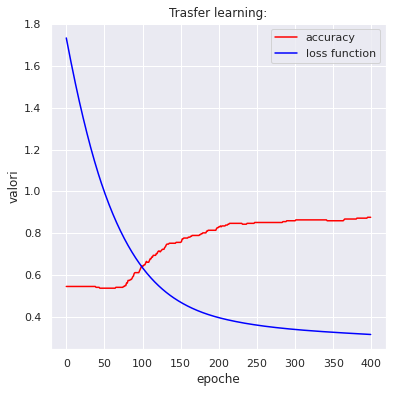

In [7]:
# Carico modello trainato con i pesi
model_TL = tf.keras.models.load_model('home/matteo/Documenti/GitHub/FromEngToArt/best2.h5')

# prendo i layers
layers = model_TL.layers

# metto tutti i layer in non trainable mode
for layer in model.layers:
    layer.trainable = False

# segno la lunghezza -1, così rimuovo l'ultimo
last_layer = len(layers)-1

# creo nuovo modello con un layer mancante
model_TL = tf.keras.Sequential(layers[:last_layer])

# metto modello precedente non trainable
#model_TL.trainable = False
# aggiungo ultimolayer per la classificazione
model_TL.add(tf.keras.layers.Dense(2,'softmax'))

# runnn
model_TL.compile(optimizer="adam",loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])
# Train sul train set
storia = model_TL.fit(x_train,y_train,epochs=400,batch_size=300)
print("TEST SET: ",model_TL.evaluate(x_test,y_test))
model_TL.summary()


pca = PCA(n_components=13)
x_reduced_pca = pca.fit_transform(x_train)
x_reduced_test_pca=pca.fit_transform(x_test)

# Train sul set della PCA
model_TL.fit(x_reduced_pca,y_train,epochs=400,batch_size=300)
print("TEST SET PCA: ",model_TL.evaluate(x_reduced_test_pca,y_test))
print("TEST SET: ",model_TL.evaluate(x_test,y_test))

plt.title('Trasfer learning:')
plt.plot(storia.history['accuracy'], color = 'red')
plt.plot(storia.history['loss'], color = 'blue')
plt.xlabel('epoche')
plt.ylabel('valori')
plt.legend(['accuracy','loss function'])


## LOAD + Train e Val SET PCA + Train e val sul TRAINING SET

trasfer learning e addestramento sui dati della pca, stessa identica cosa sopra m facendo due training, aggiuntivi su tutta la rete e senza cambiare layer finale.
primo trining sulla pca e secondo training sui dati già pre-trainati.

Epoch 1/400
1/1 [==============================] - 1s 578ms/step - loss: 0.8632 - accuracy: 0.6074
Epoch 2/400
1/1 [==============================] - 0s 4ms/step - loss: 0.8564 - accuracy: 0.6074
Epoch 3/400
1/1 [==============================] - 0s 5ms/step - loss: 0.8497 - accuracy: 0.6116
Epoch 4/400
1/1 [==============================] - 0s 5ms/step - loss: 0.8431 - accuracy: 0.6157
Epoch 5/400
1/1 [==============================] - 0s 6ms/step - loss: 0.8366 - accuracy: 0.6157
Epoch 6/400
1/1 [==============================] - 0s 5ms/step - loss: 0.8301 - accuracy: 0.6157
Epoch 7/400
1/1 [==============================] - 0s 5ms/step - loss: 0.8238 - accuracy: 0.6198
Epoch 8/400
1/1 [==============================] - 0s 6ms/step - loss: 0.8174 - accuracy: 0.6198
Epoch 9/400
1/1 [==============================] - 0s 5ms/step - loss: 0.8112 - accuracy: 0.6198
Epoch 10/400
1/1 [==============================] - 0s 4ms/step - loss: 0.8050 - accuracy: 0.6198
Epoch 11/400
1/1 [=========

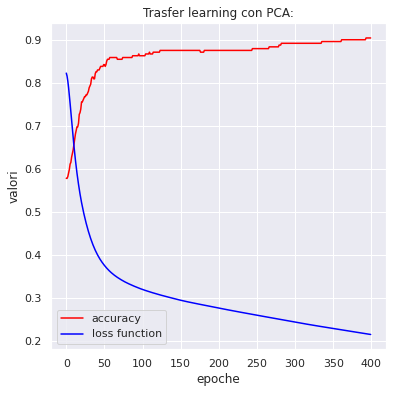

In [8]:
pca = PCA(n_components=13)
x_reduced_pca = pca.fit_transform(x_train)
x_reduced_test_pca=pca.fit_transform(x_test)

model_best2 = tf.keras.models.load_model('home/matteo/Documenti/GitHub/FromEngToArt/best2.h5')
model_best2.compile(optimizer="adam",loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=['accuracy']) 

# Train sul set della PCA
model_best2.fit(x_reduced_pca,y_train,epochs=400,batch_size=300)
print("TEST SET PCA: ",model_best2.evaluate(x_reduced_test_pca,y_test))
print("TEST SET: ",model_best2.evaluate(x_test,y_test))

model_best2.summary()
# Train sul set d'interesse
storia = model_best2.fit(x_train,y_train,epochs=400,batch_size=300)
print("TEST SET PCA: ",model_best2.evaluate(x_reduced_test_pca,y_test))
print("TEST SET: ",model_best2.evaluate(x_test,y_test))


plt.title('Trasfer learning con PCA:')
plt.plot(storia.history['accuracy'], color = 'red')
plt.plot(storia.history['loss'], color = 'blue')
plt.xlabel('epoche')
plt.ylabel('valori')
plt.legend(['accuracy','loss function'])

# LDA
## Su modello non pre addestrato

LDA non posso fare da 1 a n features con la LDA perche n_components cannot be larger than min(n_features, n_classes - 1).

Epoch 1/300
1/1 [==============================] - 1s 654ms/step - loss: 0.7579 - accuracy: 0.1653
Epoch 2/300
1/1 [==============================] - 0s 5ms/step - loss: 0.7543 - accuracy: 0.1777
Epoch 3/300
1/1 [==============================] - 0s 6ms/step - loss: 0.7506 - accuracy: 0.1694
Epoch 4/300
1/1 [==============================] - 0s 6ms/step - loss: 0.7470 - accuracy: 0.1736
Epoch 5/300
1/1 [==============================] - 0s 4ms/step - loss: 0.7435 - accuracy: 0.1612
Epoch 6/300
1/1 [==============================] - 0s 6ms/step - loss: 0.7399 - accuracy: 0.1653
Epoch 7/300
1/1 [==============================] - 0s 6ms/step - loss: 0.7364 - accuracy: 0.1446
Epoch 8/300
1/1 [==============================] - 0s 7ms/step - loss: 0.7329 - accuracy: 0.1529
Epoch 9/300
1/1 [==============================] - 0s 7ms/step - loss: 0.7295 - accuracy: 0.1488
Epoch 10/300
1/1 [==============================] - 0s 7ms/step - loss: 0.7260 - accuracy: 0.1736
Epoch 11/300
1/1 [=========

' print("------------------------------------INPUT COLUMS:{}-------------------------------------------------".format(i+1))\n    obj = modelLda.evaluate(x_test_lda,y_test)\n    if obj[1]>Best[0]:\n            Best[0] = obj[1]\n            Best[1] = "INPUT COLUMS "+str(i+1)\nplt.show()\nprint("BEST:",Best) '

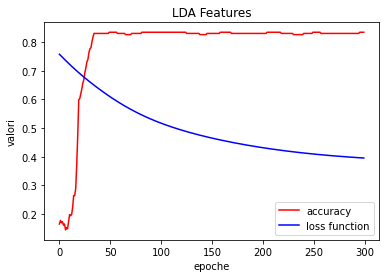

In [8]:
Best = [0,""]


#for i in range(1,):
	
lda = LinearDiscriminantAnalysis(n_components=1)
x_train_lda= lda.fit_transform(x_train, y_train)
x_test_lda = lda.fit_transform(x_test,y_test)
#print(x_test_lda.shape)
#print(y_test.shape)

modelLda = tf.keras.Sequential([
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(13,tf.keras.activations.relu),
    tf.keras.layers.Dense(2,tf.keras.activations.softmax)
])

modelLda.compile(optimizer="adam",loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])
storia = modelLda.fit(x_train_lda,y_train,batch_size=300,epochs=300)
#modelLda.evaluate(x_test,y_test)



plt.figure(i)
plt.title('LDA Features')
plt.plot(storia.history['accuracy'], color = 'red')
plt.plot(storia.history['loss'], color = 'blue')
plt.xlabel('epoche')
plt.ylabel('valori')
plt.legend(['accuracy','loss function'])
_,BestLda = modelLda.evaluate(x_test_lda,y_test)
print(BestLda)

""" print("------------------------------------INPUT COLUMS:{}-------------------------------------------------".format(i+1))
    obj = modelLda.evaluate(x_test_lda,y_test)
    if obj[1]>Best[0]:
            Best[0] = obj[1]
            Best[1] = "INPUT COLUMS "+str(i+1)
plt.show()
print("BEST:",Best) """

# PCA
## Su modello non pre addestrato

Proverei a fare un po di features selection
Con la PCA non sto ottenendo nulla, ovvero solo peggioramenti, ma la heatmap mi dice che le nuove features identificate combinando
quelle precedenti hanno meno potere espressivo

Epoch 1/300
1/1 [==============================] - 1s 635ms/step - loss: 0.8213 - accuracy: 0.4421
Epoch 2/300
1/1 [==============================] - 0s 5ms/step - loss: 0.8202 - accuracy: 0.4421
Epoch 3/300
1/1 [==============================] - 0s 5ms/step - loss: 0.8190 - accuracy: 0.4380
Epoch 4/300
1/1 [==============================] - 0s 6ms/step - loss: 0.8178 - accuracy: 0.4380
Epoch 5/300
1/1 [==============================] - 0s 6ms/step - loss: 0.8167 - accuracy: 0.4421
Epoch 6/300
1/1 [==============================] - 0s 6ms/step - loss: 0.8155 - accuracy: 0.4421
Epoch 7/300
1/1 [==============================] - 0s 5ms/step - loss: 0.8144 - accuracy: 0.4421
Epoch 8/300
1/1 [==============================] - 0s 6ms/step - loss: 0.8132 - accuracy: 0.4421
Epoch 9/300
1/1 [==============================] - 0s 5ms/step - loss: 0.8121 - accuracy: 0.4463
Epoch 10/300
1/1 [==============================] - 0s 6ms/step - loss: 0.8110 - accuracy: 0.4463
Epoch 11/300
1/1 [=========

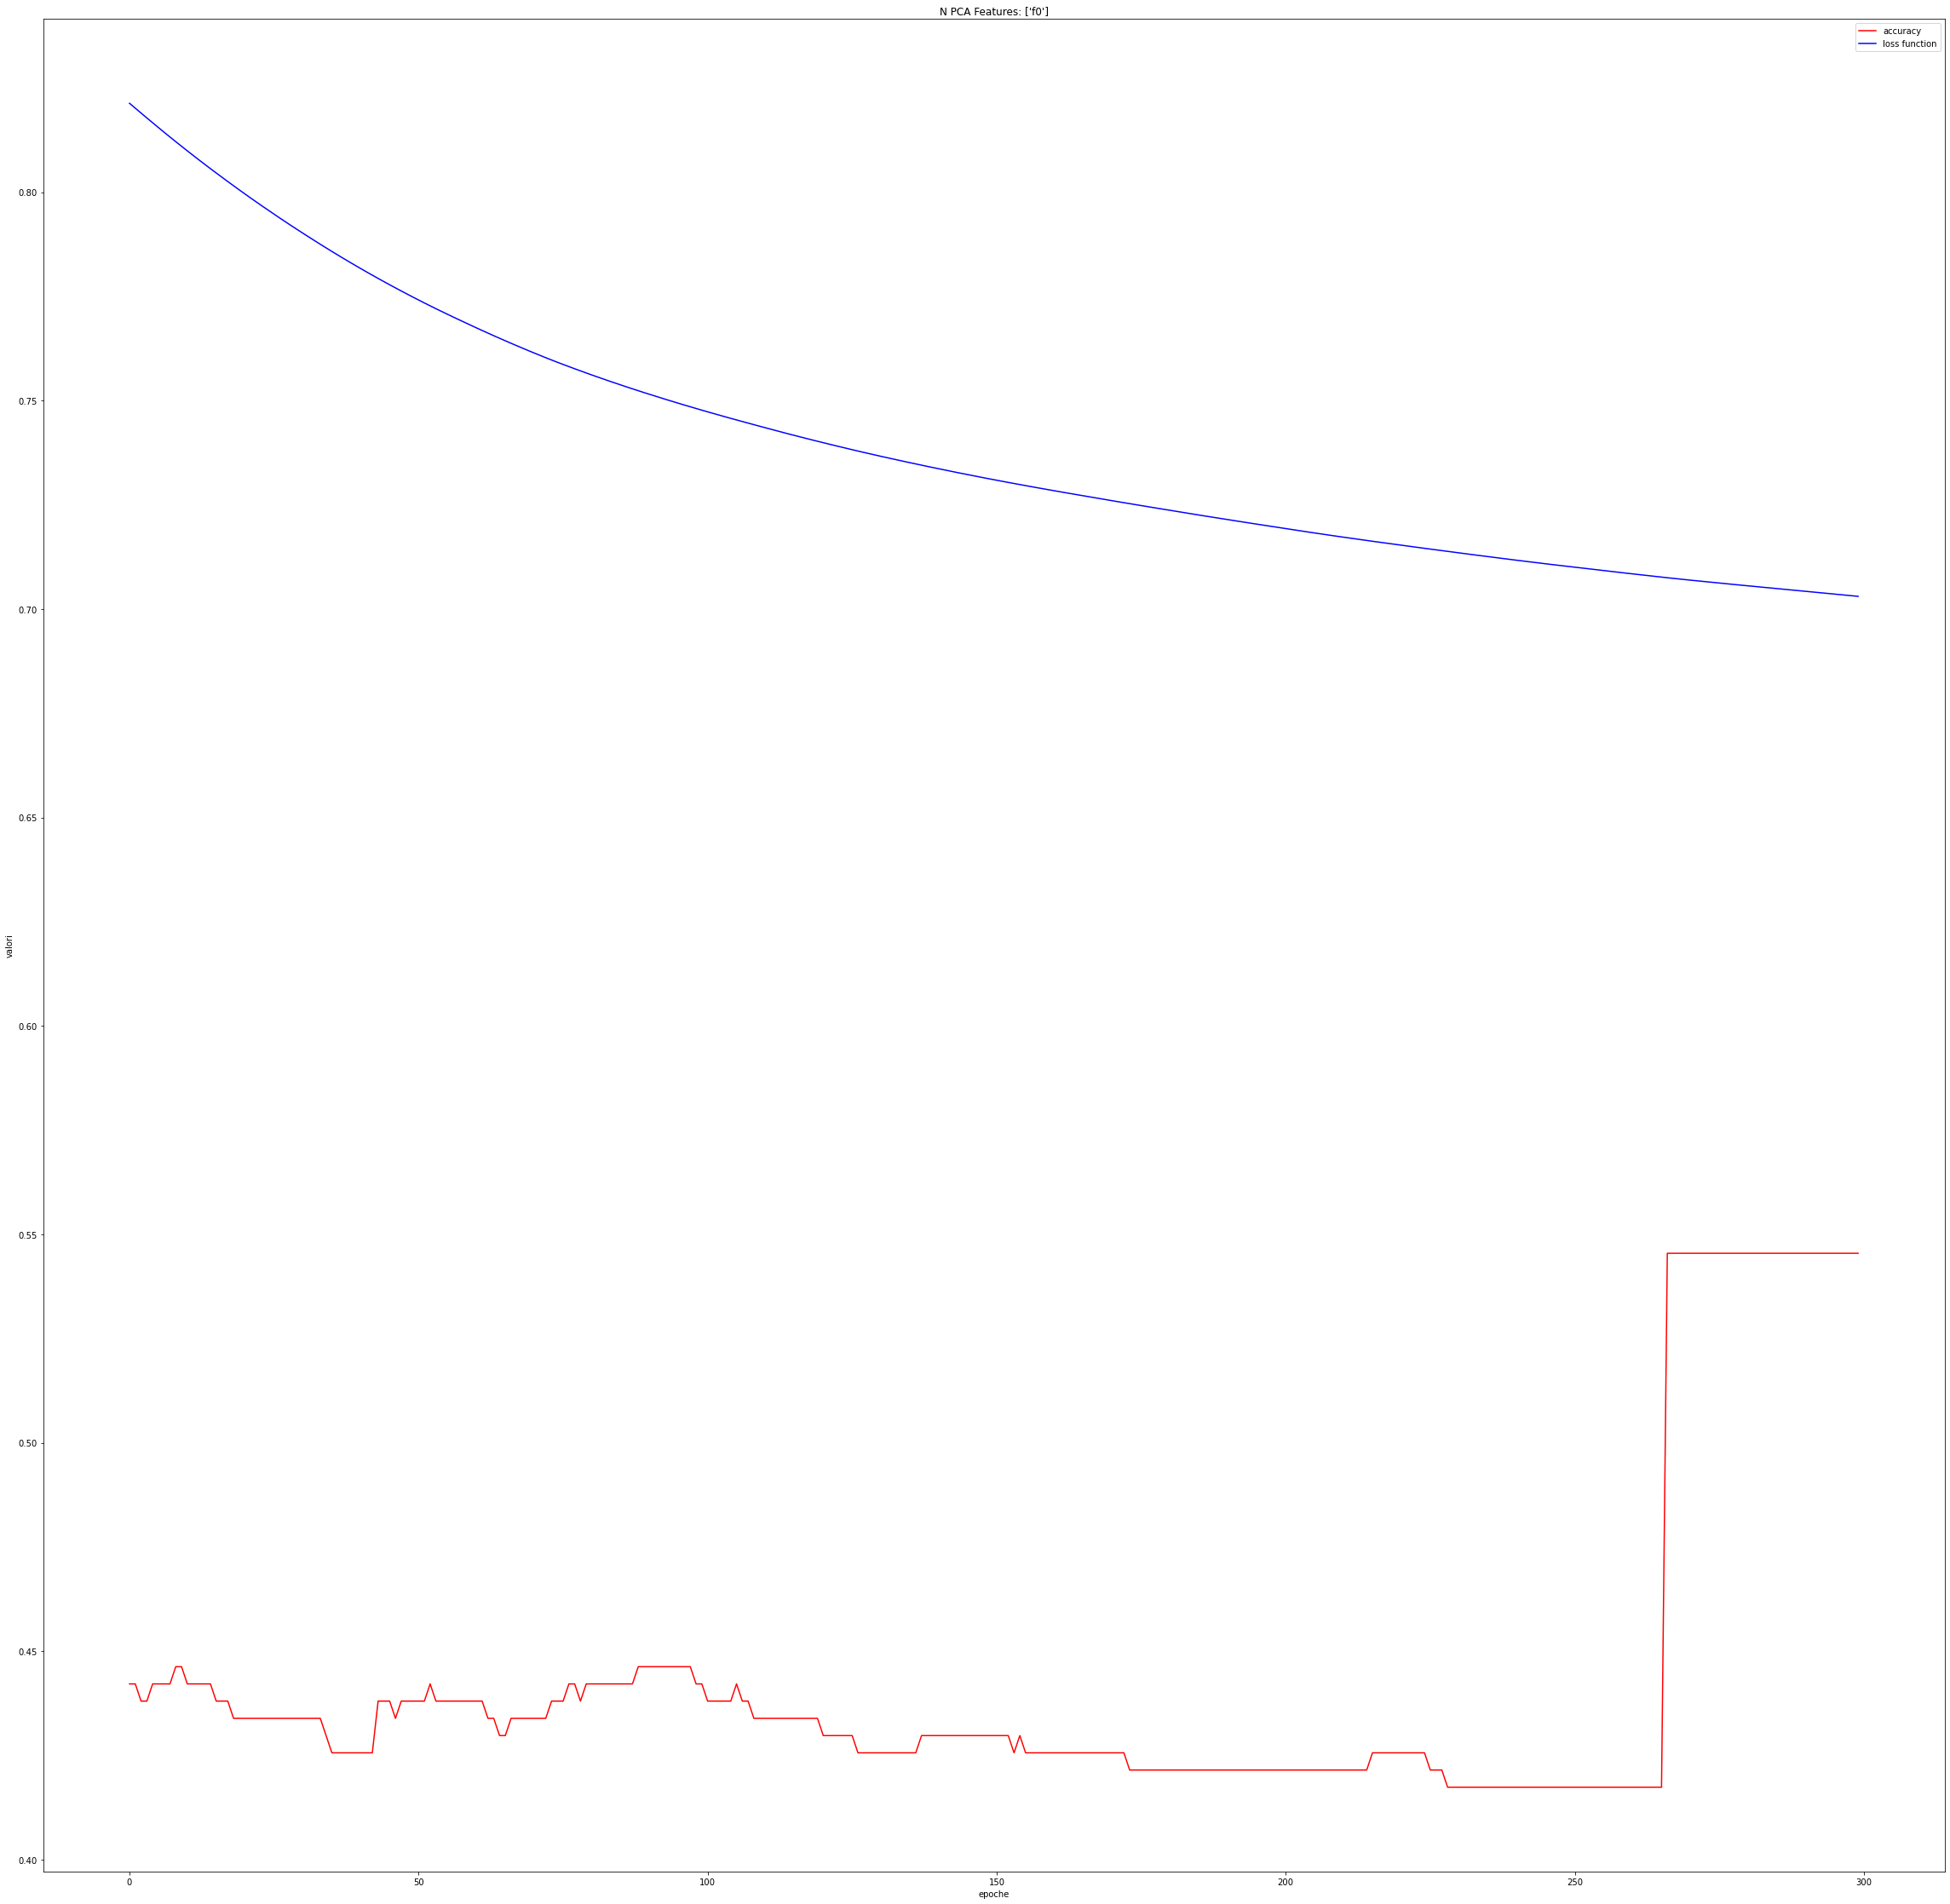

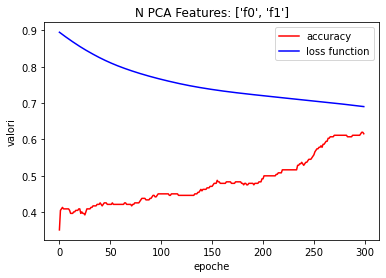

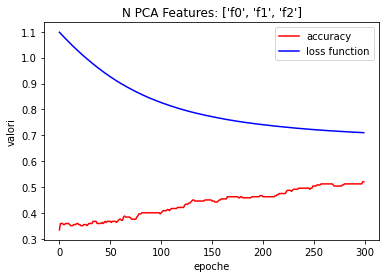

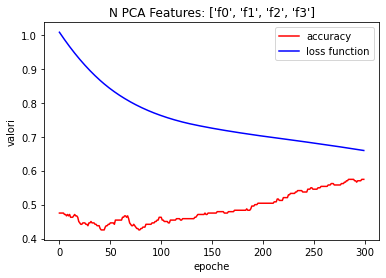

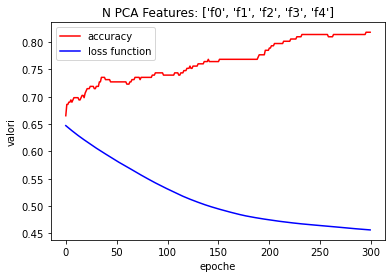

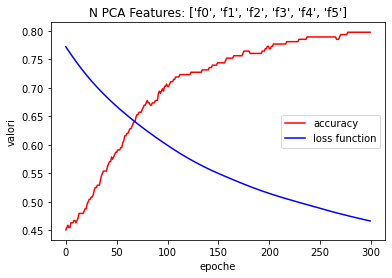

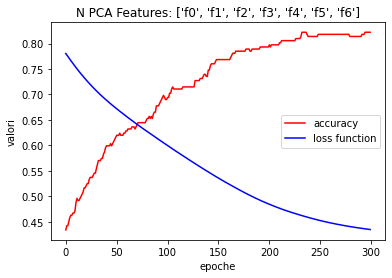

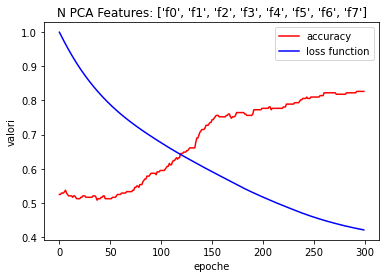

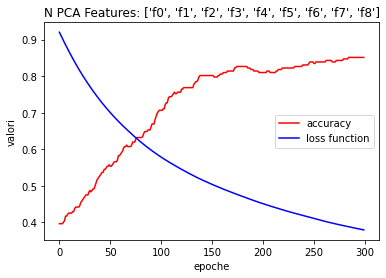

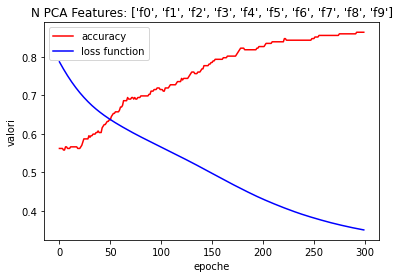

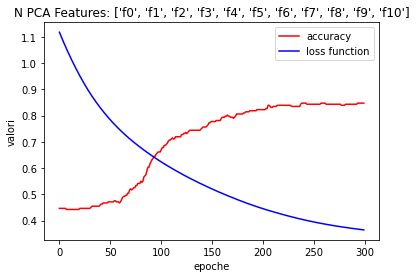

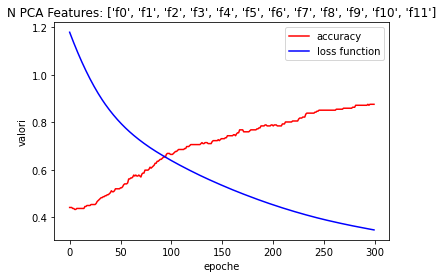

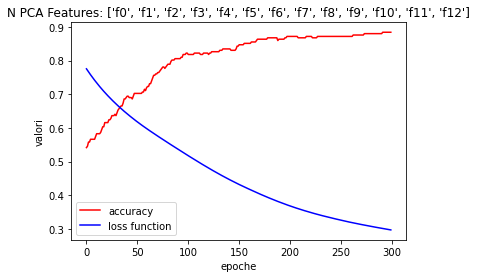

BestPca: [0.8360655903816223, 'INPUT COLUMS 6']


In [9]:
# mi serve per la visualizzazione delle heatmap in base alle features in output con la PCA
col=[
    ['f0'],
    ['f0','f1'],
    ['f0','f1','f2'],
    ['f0','f1','f2','f3'],
    ['f0','f1','f2','f3','f4'],
    ['f0','f1','f2','f3','f4','f5'],
    ['f0','f1','f2','f3','f4','f5','f6'],
    ['f0','f1','f2','f3','f4','f5','f6','f7'],
    ['f0','f1','f2','f3','f4','f5','f6','f7','f8'],
    ['f0','f1','f2','f3','f4','f5','f6','f7','f8','f9'],
    ['f0','f1','f2','f3','f4','f5','f6','f7','f8','f9','f10'],
    ['f0','f1','f2','f3','f4','f5','f6','f7','f8','f9','f10','f11'],
    ['f0','f1','f2','f3','f4','f5','f6','f7','f8','f9','f10','f11','f12']
    ] 

BestPca = [0,""]

fig = plt.figure(figsize = (40,40)) # width x height
index = 1
pca = PCA()
pca.fit(x_train)

# i lo uso per il numero di features in output che voglio, mi combina le mie in una/due/.../13 features nuove
# ovviamento più riduco più perdo informazione, le comprimo dippiu
# piu aumento piu conservo informazione
for i in range(1,14):

    #n_components sono il numero di features nuove che voglio in output
    pca = PCA(n_components=i)
    x_reduced_pca = pca.fit_transform(x_train)
    x_reduced_test_pca=pca.fit_transform(x_test)
    
    #ax1 = fig.add_subplot(2, 13, i) # righe, colonne, posizione
    #sns.set (rc = {'figure.figsize':(9, 9)})
    #h = pd.DataFrame(x_reduced_pca,columns=col[i-1])
    """ sns.heatmap(h.corr(), 
                    cbar=True, 
                    annot=True, 
                    square=True, 
                    vmax=1,
                    vmin=0,
                    fmt='.2f', 
                    annot_kws={'size': 10}, 
                    yticklabels=h.columns, 
                    xticklabels=h.columns, ) """

    modelPca = tf.keras.Sequential([
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(i,tf.keras.activations.relu),
        tf.keras.layers.Dense(2,tf.keras.activations.softmax)
    ])
    """ tf.keras.layers.BatchNormalization(), """

    """ tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.4),
        #tf.keras.layers.Dense(100,tf.keras.activations.gelu),
        tf.keras.layers.Dense(96,tf.keras.activations.gelu),
        #tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(64,tf.keras.activations.gelu),
        
        #tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(32,tf.keras.activations.gelu),
        #tf.keras.layers.Dropout(0.7),
        tf.keras.layers.Dense(16,tf.keras.activations.gelu),
        #tf.keras.layers.Dropout(0.7),
        tf.keras.layers.Dense(8,tf.keras.activations.gelu),
        #tf.keras.layers.Dropout(0.7),
        tf.keras.layers.Dense(4,tf.keras.activations.gelu),
        #tf.keras.layers.Dropout(0.7), """

    modelPca.compile(optimizer="adam",loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])
    storia = modelPca.fit(x_reduced_pca,y_train,batch_size=300,epochs=300)

    plt.figure(i)
    plt.title('N PCA Features: '+str(col[i-1]))
    plt.plot(storia.history['accuracy'], color = 'red')
    plt.plot(storia.history['loss'], color = 'blue')
    plt.xlabel('epoche')
    plt.ylabel('valori')
    plt.legend(['accuracy','loss function'])

    print("------------------------------------INPUT COLUMS:{}-------------------------------------------------".format(i+1))
    obj = modelPca.evaluate(x_reduced_test_pca,y_test)
    if obj[1]>BestPca[0]:
        BestPca[0] = obj[1]
        BestPca[1] = "INPUT COLUMS "+str(i+1)
plt.show()
print("BestPca:",BestPca)

# Neural Network si tensorflow pre-fabric

In [10]:
MLP = MLPClassifier(hidden_layer_sizes=(128),
                       learning_rate="adaptive",
                       max_iter=500,solver="lbfgs",
                       activation="relu",
                       early_stopping=True)

model = MLP.fit(x_train, y_train)
MLP_predict = MLP.predict(x_test)
MLP_conf_matrix = confusion_matrix(y_test, MLP_predict)
MLP_acc_score = accuracy_score(y_test, MLP_predict)

print(MLP_conf_matrix)
print("\n")
print(classification_report(y_test,MLP_predict))
accuracyNN= MLP_acc_score*100
print("Accuracy of Multilayer Perceptron classifier: {:.3f}".format(accuracyNN),'%\n')

[[21  7]
 [ 0 33]]


              precision    recall  f1-score   support

           0       1.00      0.75      0.86        28
           1       0.82      1.00      0.90        33

    accuracy                           0.89        61
   macro avg       0.91      0.88      0.88        61
weighted avg       0.91      0.89      0.88        61

Accuracy of Multilayer Perceptron classifier: 88.525 %



/home/matteo/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


# Modelli machine learning

In [11]:
knn = KNeighborsClassifier(n_neighbors=3)

# Addestramento del classificatore
storia = knn.fit(x_train, y_train)

# Classificazione dei dati di test
y_predKnn = knn.predict(x_test)

# Calcolo dell'accuratezza
accuracyKnn = accuracy_score(y_test, y_predKnn)
print("Accuratezza: ", accuracyKnn)


Accuratezza:  0.6557377049180327


In [12]:
classBayesiano = GaussianNB()

# Addestramento del classificatore
classBayesiano.fit(x_train, y_train)

# Classificazione dei dati di test
y_predB = classBayesiano.predict(x_test)

# Calcolo dell'accuratezza
accuracyCB = accuracy_score(y_test, y_predB)
print("Accuratezza: ", accuracyCB)


Accuratezza:  0.9016393442622951


In [4]:
svm = svm.SVC(kernel='linear')

# Addestramento del classificatore
svm.fit(x_train, y_train)

# Classificazione dei dati di test
y_predSVM = svm.predict(x_test)

# Calcolo dell'accuratezza
accuracySVM = accuracy_score(y_test, y_predSVM)
print("Accuratezza: ", accuracySVM)

Accuratezza:  0.9016393442622951


In [13]:
randomForest = RandomForestClassifier(n_estimators=100)

# Addestramento del classificatore
randomForest.fit(x_train, y_train)

# Classificazione dei dati di test
y_predRF = randomForest.predict(x_test)

# Calcolo dell'accuratezza
accuracyRF = accuracy_score(y_test, y_predRF)
print("Accuratezza: ", accuracyRF)

Accuratezza:  0.9016393442622951


In [14]:
decisionTree = DecisionTreeClassifier()

# Addestramento del classificatore
decisionTree.fit(x_train, y_train)

# Classificazione dei dati di test
y_predDT = decisionTree.predict(x_test)

# Calcolo dell'accuratezza
accuracyDT = accuracy_score(y_test, y_predDT)
print("Accuratezza: ", accuracyDT)

Accuratezza:  0.8032786885245902


# Enseble
## Confronto meta-classificatori che usano classificatori

sono dei meta classificatori, ovvero fanno uso di più modelli di classificazioni che vengono addestrati su porzioni di dataset diversi, e per fare la lassificazione finale mettono insieme gli output e in base a tecniche diverse il meta-classificatore classifica l'output in base agli output dei modelli addestrati.

In [23]:
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier


# il Voting combina le predizioni di modelli di base indipendenti tramite voto
vC = VotingClassifier(estimators=[('model1',decisionTree),('model2',randomForest),('model3',classBayesiano),('model',svm),('model4',knn)],voting='hard')
vC.fit(x_train,y_train)
accuracyVC = vC.score(x_test,y_test)
print('Accuracy VotingClassifier: ',accuracyVC)

# lo Stacking utilizza un modello meta per combinare le predizioni dei modelli di base da dare in input ad un classificatore
sC = StackingClassifier(estimators=[('model1',decisionTree),('model2',randomForest),('model3',classBayesiano),('model',svm),('model4',knn)])
sC.fit(x_train,y_train)
accuracySC = sC.score(x_test,y_test)
print('Accuracy StackingClassifier: ',accuracySC)

#  il Bagging si concentra sulla creazione di diverse copie dello stesso modello di base 
# addestrato su repliche dei dati di addestramento
bC = BaggingClassifier(estimator=classBayesiano,n_estimators=100)
bC.fit(x_train,y_train)
accuracyBC = bC.score(x_test,y_test)
print('Accuracy BaggingClassifier: ',accuracyBC)

aB = AdaBoostClassifier(estimator=svm,n_estimators=100,algorithm='SAMME')
aB.fit(x_train,y_train)
accuracyAB = aB.score(x_test,y_test)
print('Accuracy AdaBoostClassifier: ',accuracyAB)


Accuracy VotingClassifier:  0.8852459016393442
Accuracy StackingClassifier:  0.9016393442622951
Accuracy BaggingClassifier:  0.9016393442622951
Accuracy AdaBoostClassifier:  0.8852459016393442


# Confronto Modelli

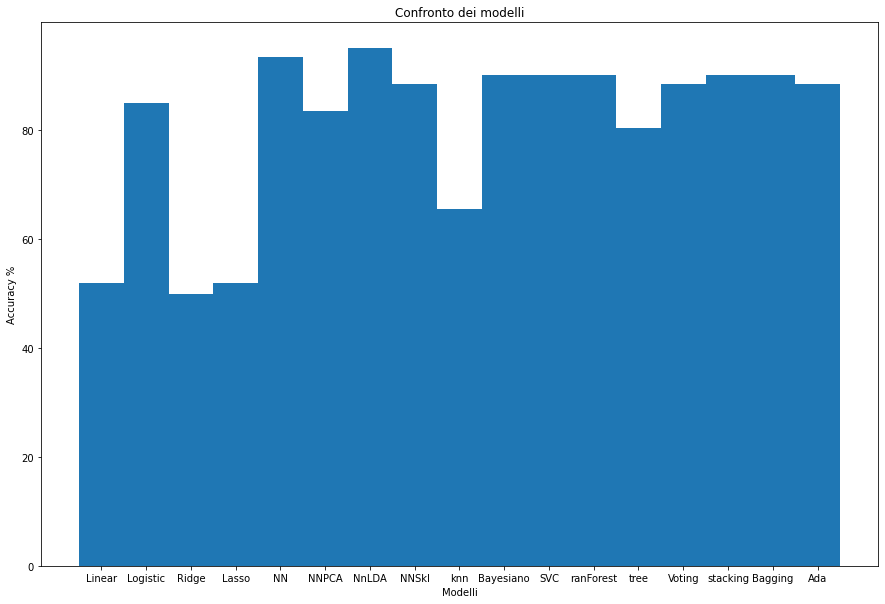

In [21]:

models = ['Linear','Logistic', 'Ridge', 'Lasso', 'NN','NNPCA','NnLDA','NNSkl','knn','Bayesiano','SVC','ranForest','tree','Voting','stacking','Bagging','Ada']
values = [52, 85, 50, 52, accuracyModel*100,BestPca[0]*100 ,BestLda*100 ,accuracyNN, accuracyKnn*100, accuracyCB*100, accuracySVM*100, accuracyRF*100, accuracyDT*100, accuracyVC*100, accuracySC*100, accuracyBC*100, accuracyAB*100]

plt.figure(figsize=(15,10))
plt.bar(models, values, width=1)  # Imposta la larghezza delle colonne a 0.6
plt.xlabel('Modelli')
plt.ylabel('Accuracy %')
plt.title('Confronto dei modelli')
plt.show()
